In [1]:
#standard ds imports
import pandas as pd
import numpy as np

#viz and stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

import os
import env

from sklearn.model_selection import train_test_split

# Acquire

In [2]:
def get_connection(db: str, user: str = env.user, host: str = env.host, password=env.password) -> str: # add to wrangle file 
    return f"mysql+pymysql://{user}:{password}@{host}/{db}"


In [3]:
def get_zillow_data(file_name="zillow.csv") -> pd.DataFrame: # add to wrangle file 
    if os.path.isfile(file_name):
        return pd.read_csv(file_name)
    query = """select propertylandusedesc, bedroomcnt, 
               bathroomcnt, calculatedfinishedsquarefeet, 
               taxvaluedollarcnt, yearbuilt, taxamount, fips
               from propertylandusetype 
               join properties_2017
               using (propertylandusetypeid)
               where propertylandusedesc = 'Single Family Residential'
            """
    connection = get_connection("zillow")
    df = pd.read_sql(query, connection)
    df.to_csv(file_name, index=False)
    return df

In [4]:
df = get_zillow_data()
df.head(3) # first look at the data 

,propertylandusedesc,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,Single Family Residential,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,Single Family Residential,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,Single Family Residential,0.0,0.0,NaN,10.0,NaN,NaN,6037.0


# Prepare

In [5]:
df.info() # viewing the data types 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152863 entries, 0 to 2152862
Data columns (total 8 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   propertylandusedesc           object 
 1   bedroomcnt                    float64
 2   bathroomcnt                   float64
 3   calculatedfinishedsquarefeet  float64
 4   taxvaluedollarcnt             float64
 5   yearbuilt                     float64
 6   taxamount                     float64
 7   fips                          float64
dtypes: float64(7), object(1)
memory usage: 131.4+ MB


In [6]:
df.describe().T # viewing descriptive statistics 

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2152852.0,3.287196,0.954754,0.00,3.00,3.00,4.00,25.00
bathroomcnt,2152852.0,2.230688,0.999280,0.00,2.00,2.00,3.00,32.00
calculatedfinishedsquarefeet,2144379.0,1862.855178,1222.125124,1.00,1257.00,1623.00,2208.00,952576.00
taxvaluedollarcnt,2152370.0,461896.237963,699676.049600,1.00,188170.25,327671.00,534527.00,98428909.00
yearbuilt,2143526.0,1960.949681,22.162196,1801.00,1949.00,1958.00,1976.00,2016.00
taxamount,2148421.0,5634.865978,8178.910249,1.85,2534.98,4108.95,6414.32,1337755.86
fips,2152863.0,6048.377335,20.433292,6037.00,6037.00,6037.00,6059.00,6111.00


In [7]:
df = df.rename(columns = {'bedroomcnt':'bed_rooms', 'bathroomcnt':'bath_rooms', 'calculatedfinishedsquarefeet':'finished_sqft', 
                          'taxvaluedollarcnt':'tax_value', 'fips':'county', 'yearbuilt': 'year_built', 'taxamount': 'tax_amount'})

df.head(3) # renamed columns for better understanding 

,propertylandusedesc,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county
0,Single Family Residential,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,Single Family Residential,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,Single Family Residential,0.0,0.0,NaN,10.0,NaN,NaN,6037.0


In [8]:
df.isnull().sum() # can see how many null values per column  

propertylandusedesc       0
bed_rooms                11
bath_rooms               11
finished_sqft          8484
tax_value               493
year_built             9337
tax_amount             4442
county                    0
dtype: int64

In [9]:
df.isnull().mean() # can see the percentage of null values per columns 

propertylandusedesc    0.000000
bed_rooms              0.000005
bath_rooms             0.000005
finished_sqft          0.003941
tax_value              0.000229
year_built             0.004337
tax_amount             0.002063
county                 0.000000
dtype: float64

In [10]:
df = df.dropna() # dropping all null values because every null made up less than one percent of thier respective column. 
                 # our dataset is large so dropping then will not infuance our data significatly  

df.isnull().sum()

propertylandusedesc    0
bed_rooms              0
bath_rooms             0
finished_sqft          0
tax_value              0
year_built             0
tax_amount             0
county                 0
dtype: int64

In [11]:
make_ints = ['bed_rooms', 'finished_sqft', 'tax_value', 'year_built', 'county'] 

for col in make_ints:
    df[col] = df[col].astype(int)

df.info() # convert floats into ints 

<class 'pandas.core.frame.DataFrame'>
Index: 2140235 entries, 4 to 2152862
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   propertylandusedesc  object 
 1   bed_rooms            int64  
 2   bath_rooms           float64
 3   finished_sqft        int64  
 4   tax_value            int64  
 5   year_built           int64  
 6   tax_amount           float64
 7   county               int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 147.0+ MB


In [12]:
df.head(3)

,propertylandusedesc,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county
4,Single Family Residential,4,2.0,3633,296425,2005,6941.39,6037
6,Single Family Residential,3,4.0,1620,847770,2011,10244.94,6037
7,Single Family Residential,3,2.0,2077,646760,1926,7924.68,6037


In [13]:
def wrangle_zillow(df: pd.DataFrame) -> pd.DataFrame: # add to wrangle file 
    '''
    This function takes in a dataframe
    renames the columns and drops nulls values
    Additionally it changes datatypes for appropriate columns.
    Then returns a cleaned dataframe
    '''
    df = df.rename(columns = {'bedroomcnt':'bed_rooms', 'bathroomcnt':'bath_rooms', 'calculatedfinishedsquarefeet':'finished_sqft', 
                          'taxvaluedollarcnt':'tax_value', 'fips':'county', 'yearbuilt': 'year_built', 'taxamount': 'tax_amount'})
    
    df = df.dropna()
    
    make_ints = ['bed_rooms','finished_sqft','tax_value','year_built', 'county']

    for col in make_ints:
        df[col] = df[col].astype(int)
        
    return df


### testing out the function 

In [14]:
new_df = get_zillow_data()
new_df.head(3) # get fresh data to test 

,propertylandusedesc,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,Single Family Residential,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,Single Family Residential,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,Single Family Residential,0.0,0.0,NaN,10.0,NaN,NaN,6037.0


In [15]:
wrangle_zillow(new_df) # verify 

,propertylandusedesc,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county
4,Single Family Residential,4,2.0,3633,296425,2005,6941.39,6037
6,Single Family Residential,3,4.0,1620,847770,2011,10244.94,6037
7,Single Family Residential,3,2.0,2077,646760,1926,7924.68,6037
11,Single Family Residential,0,0.0,1200,5328,1972,91.60,6037
14,Single Family Residential,0,0.0,171,6920,1973,255.17,6037
...,...,...,...,...,...,...,...,...
2152856,Single Family Residential,4,4.0,4375,422400,2015,13877.56,6037
2152858,Single Family Residential,4,3.0,2262,960756,2015,13494.52,6059
2152859,Single Family Residential,4,4.5,3127,536061,2014,6244.16,6059
2152861,Single Family Residential,3,2.5,1974,424353,2015,5302.70,6059


In [16]:
def get_all_zillow_data(file_name="zillow_all.csv") -> pd.DataFrame: # add to wrangle file 
    if os.path.isfile(file_name):
        return pd.read_csv(file_name)
    query = """select propertylandusedesc, parcelid, bedroomcnt, 
bathroomcnt, calculatedfinishedsquarefeet, 
taxvaluedollarcnt, yearbuilt, taxamount, fips, 
logerror, transactiondate
from propertylandusetype 
left join properties_2017
using (propertylandusetypeid)
left join predictions_2017
using(parcelid)
where propertylandusedesc = 'Single Family Residential';
            """
    connection = get_connection("zillow")
    df = pd.read_sql(query, connection)
    df.to_csv(file_name, index=False)
    return df

# second dataframe 

In [17]:
zillow_df = get_all_zillow_data()

zillow_df.head(3)

,propertylandusedesc,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,logerror,transactiondate
0,Single Family Residential,11007640,3.0,2.0,1572.0,305307.0,1976.0,3887.80,6037.0,0.020360,2017-01-12
1,Single Family Residential,10821119,2.0,2.0,1430.0,381638.0,1952.0,4692.27,6037.0,0.025629,2017-01-03
2,Single Family Residential,17173851,4.0,2.0,1848.0,64712.0,1952.0,781.00,6111.0,0.088469,2017-01-03


In [18]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152985 entries, 0 to 2152984
Data columns (total 11 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   propertylandusedesc           object 
 1   parcelid                      int64  
 2   bedroomcnt                    float64
 3   bathroomcnt                   float64
 4   calculatedfinishedsquarefeet  float64
 5   taxvaluedollarcnt             float64
 6   yearbuilt                     float64
 7   taxamount                     float64
 8   fips                          float64
 9   logerror                      float64
 10  transactiondate               object 
dtypes: float64(8), int64(1), object(2)
memory usage: 180.7+ MB


In [19]:
zillow_df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,2152985.0,1.309662e+07,5.172434e+06,1.071172e+07,1.165907e+07,1.259850e+07,1.405608e+07,1.696019e+08
bedroomcnt,2152974.0,3.287195e+00,9.547910e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,2.500000e+01
bathroomcnt,2152974.0,2.230677e+00,9.992790e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.200000e+01
calculatedfinishedsquarefeet,2144500.0,1.862852e+03,1.222120e+03,1.000000e+00,1.257000e+03,1.623000e+03,2.208000e+03,9.525760e+05
taxvaluedollarcnt,2152492.0,4.618967e+05,6.996805e+05,1.000000e+00,1.881638e+05,3.276710e+05,5.345212e+05,9.842891e+07
yearbuilt,2143646.0,1.960949e+03,2.216238e+01,1.801000e+03,1.949000e+03,1.958000e+03,1.976000e+03,2.016000e+03
taxamount,2148543.0,5.634881e+03,8.179022e+03,1.850000e+00,2.534920e+03,4.108900e+03,6.414300e+03,1.337756e+06
fips,2152985.0,6.048377e+03,2.043332e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
logerror,52442.0,1.829437e-02,1.775018e-01,-4.655420e+00,-2.463935e-02,7.009984e-03,4.069098e-02,5.262999e+00


In [20]:
zillow_df = zillow_df.rename(columns={'parcelid': 'parcel_id', 'logerror': 'log_error', 'transactiondate': 'transaction_date', 
                        'bedroomcnt':'bed_rooms', 'bathroomcnt':'bath_rooms', 'calculatedfinishedsquarefeet':'finished_sqft', 
                        'taxvaluedollarcnt':'tax_value', 'fips':'county', 'yearbuilt': 'year_built', 'taxamount': 'tax_amount'})

zillow_df.columns

Index(['propertylandusedesc', 'parcel_id', 'bed_rooms', 'bath_rooms',
       'finished_sqft', 'tax_value', 'year_built', 'tax_amount', 'county',
       'log_error', 'transaction_date'],
      dtype='object')

In [21]:
zillow_df.isnull().sum()

propertylandusedesc          0
parcel_id                    0
bed_rooms                   11
bath_rooms                  11
finished_sqft             8485
tax_value                  493
year_built                9339
tax_amount                4442
county                       0
log_error              2100543
transaction_date       2100543
dtype: int64

In [22]:
zillow_df.isnull().mean()

propertylandusedesc    0.000000
parcel_id              0.000000
bed_rooms              0.000005
bath_rooms             0.000005
finished_sqft          0.003941
tax_value              0.000229
year_built             0.004338
tax_amount             0.002063
county                 0.000000
log_error              0.975642
transaction_date       0.975642
dtype: float64

In [23]:
zillow_df = zillow_df.dropna() # dropping all null values because every null made up less than one percent of thier respective column. 
                 # our dataset is large so dropping then will not infuance our data significatly  
zillow_df.isnull().sum()

propertylandusedesc    0
parcel_id              0
bed_rooms              0
bath_rooms             0
finished_sqft          0
tax_value              0
year_built             0
tax_amount             0
county                 0
log_error              0
transaction_date       0
dtype: int64

In [24]:
zillow_df.shape

(52316, 11)

In [25]:
make_ints = ['bed_rooms', 'finished_sqft', 'tax_value', 'year_built', 'county'] 

for col in make_ints:
    zillow_df[col] = zillow_df[col].astype(int)

zillow_df.info() # convert floats into ints 

<class 'pandas.core.frame.DataFrame'>
Index: 52316 entries, 0 to 2152967
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   propertylandusedesc  52316 non-null  object 
 1   parcel_id            52316 non-null  int64  
 2   bed_rooms            52316 non-null  int64  
 3   bath_rooms           52316 non-null  float64
 4   finished_sqft        52316 non-null  int64  
 5   tax_value            52316 non-null  int64  
 6   year_built           52316 non-null  int64  
 7   tax_amount           52316 non-null  float64
 8   county               52316 non-null  int64  
 9   log_error            52316 non-null  float64
 10  transaction_date     52316 non-null  object 
dtypes: float64(3), int64(6), object(2)
memory usage: 4.8+ MB


In [26]:
zillow_df.head(3)

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
0,Single Family Residential,11007640,3,2.0,1572,305307,1976,3887.80,6037,0.020360,2017-01-12
1,Single Family Residential,10821119,2,2.0,1430,381638,1952,4692.27,6037,0.025629,2017-01-03
2,Single Family Residential,17173851,4,2.0,1848,64712,1952,781.00,6111,0.088469,2017-01-03


In [48]:
for character in '-':
    zillow_df.transaction_date = zillow_df.transaction_date.str.replace(character, '')

zillow_df.head(2)

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
0,Single Family Residential,11007640,3,2.0,1572,305307,1976,3887.80,6037,0.020360,20170112
1,Single Family Residential,10821119,2,2.0,1430,381638,1952,4692.27,6037,0.025629,20170103


In [49]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52316 entries, 0 to 2152967
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   propertylandusedesc  52316 non-null  object 
 1   parcel_id            52316 non-null  int64  
 2   bed_rooms            52316 non-null  int64  
 3   bath_rooms           52316 non-null  float64
 4   finished_sqft        52316 non-null  int64  
 5   tax_value            52316 non-null  int64  
 6   year_built           52316 non-null  int64  
 7   tax_amount           52316 non-null  float64
 8   county               52316 non-null  int64  
 9   log_error            52316 non-null  float64
 10  transaction_date     52316 non-null  object 
dtypes: float64(3), int64(6), object(2)
memory usage: 4.8+ MB


In [53]:
zillow_df['transaction_date'].astype(str).astype(int)

zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52316 entries, 0 to 2152967
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   propertylandusedesc  52316 non-null  object 
 1   parcel_id            52316 non-null  int64  
 2   bed_rooms            52316 non-null  int64  
 3   bath_rooms           52316 non-null  float64
 4   finished_sqft        52316 non-null  int64  
 5   tax_value            52316 non-null  int64  
 6   year_built           52316 non-null  int64  
 7   tax_amount           52316 non-null  float64
 8   county               52316 non-null  int64  
 9   log_error            52316 non-null  float64
 10  transaction_date     52316 non-null  object 
dtypes: float64(3), int64(6), object(2)
memory usage: 4.8+ MB


## Split the data 

In [29]:
def split_data(df: pd.DataFrame) -> pd.DataFrame: # add to wrangle 
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate,
                                       test_size=.3,
                                       random_state=123)
    return train, validate, test

In [30]:
def view_split(train, validate, test):
    print(f'train    -> {train.shape}')
    print(f'validate -> {validate.shape}')
    print(f'test     -> {test.shape}')
    

In [31]:
train, validate, test = split_data(zillow_df)


print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (29296, 11)
validate -> (12556, 11)
test -> (10464, 11)


# Explore 

In [32]:
train.head(3)

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
504114,Single Family Residential,14481410,4,2.5,2439,673754,1987,6850.00,6059,-0.122219,2017-05-05
29686,Single Family Residential,12676325,3,1.0,1112,708000,1954,8144.78,6037,-0.003290,2017-04-10
474808,Single Family Residential,12129843,3,3.0,2670,965305,1979,11249.58,6037,0.080942,2017-07-13


In [33]:
>>> df.drop(columns=['B', 'C'])
   A   D
0  0   3
1  4   7
2  8  11

IndentationError: unexpected indent (1437435306.py, line 2)

In [ ]:
train_explore = train.drop(columns=['propertylandusedesc', 'transaction_date'])

train_explore.head()

,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error
504114,14481410,4,2.5,2439,673754,1987,6850.00,6059,-0.122219
29686,12676325,3,1.0,1112,708000,1954,8144.78,6037,-0.003290
474808,12129843,3,3.0,2670,965305,1979,11249.58,6037,0.080942
1526724,11203682,4,2.0,1703,201000,1971,3323.01,6037,0.212506
265675,14066903,3,2.0,1146,469692,1965,5395.32,6059,0.014152


In [ ]:
cols = train[['bed_rooms', 'bath_rooms', 'finished_sqft']]

def plot_variable_pair(df):
    for i in cols:
        sns.lmplot(x=i, y="tax_value", data=train, line_kws={'color': 'red'})
        plt.show()

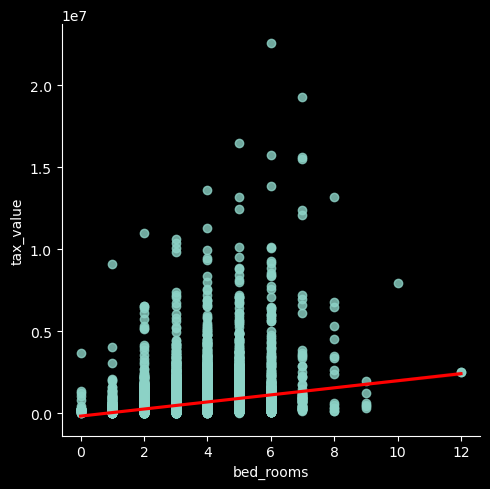

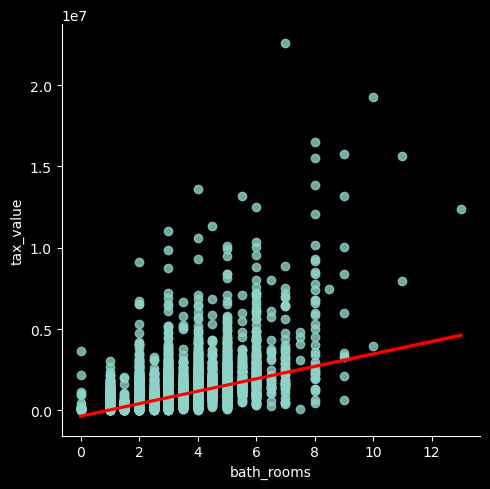

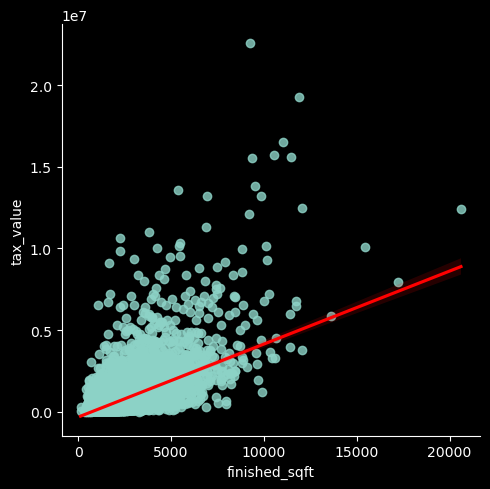

In [ ]:
plot_variable_pair(train) # inital look at the data

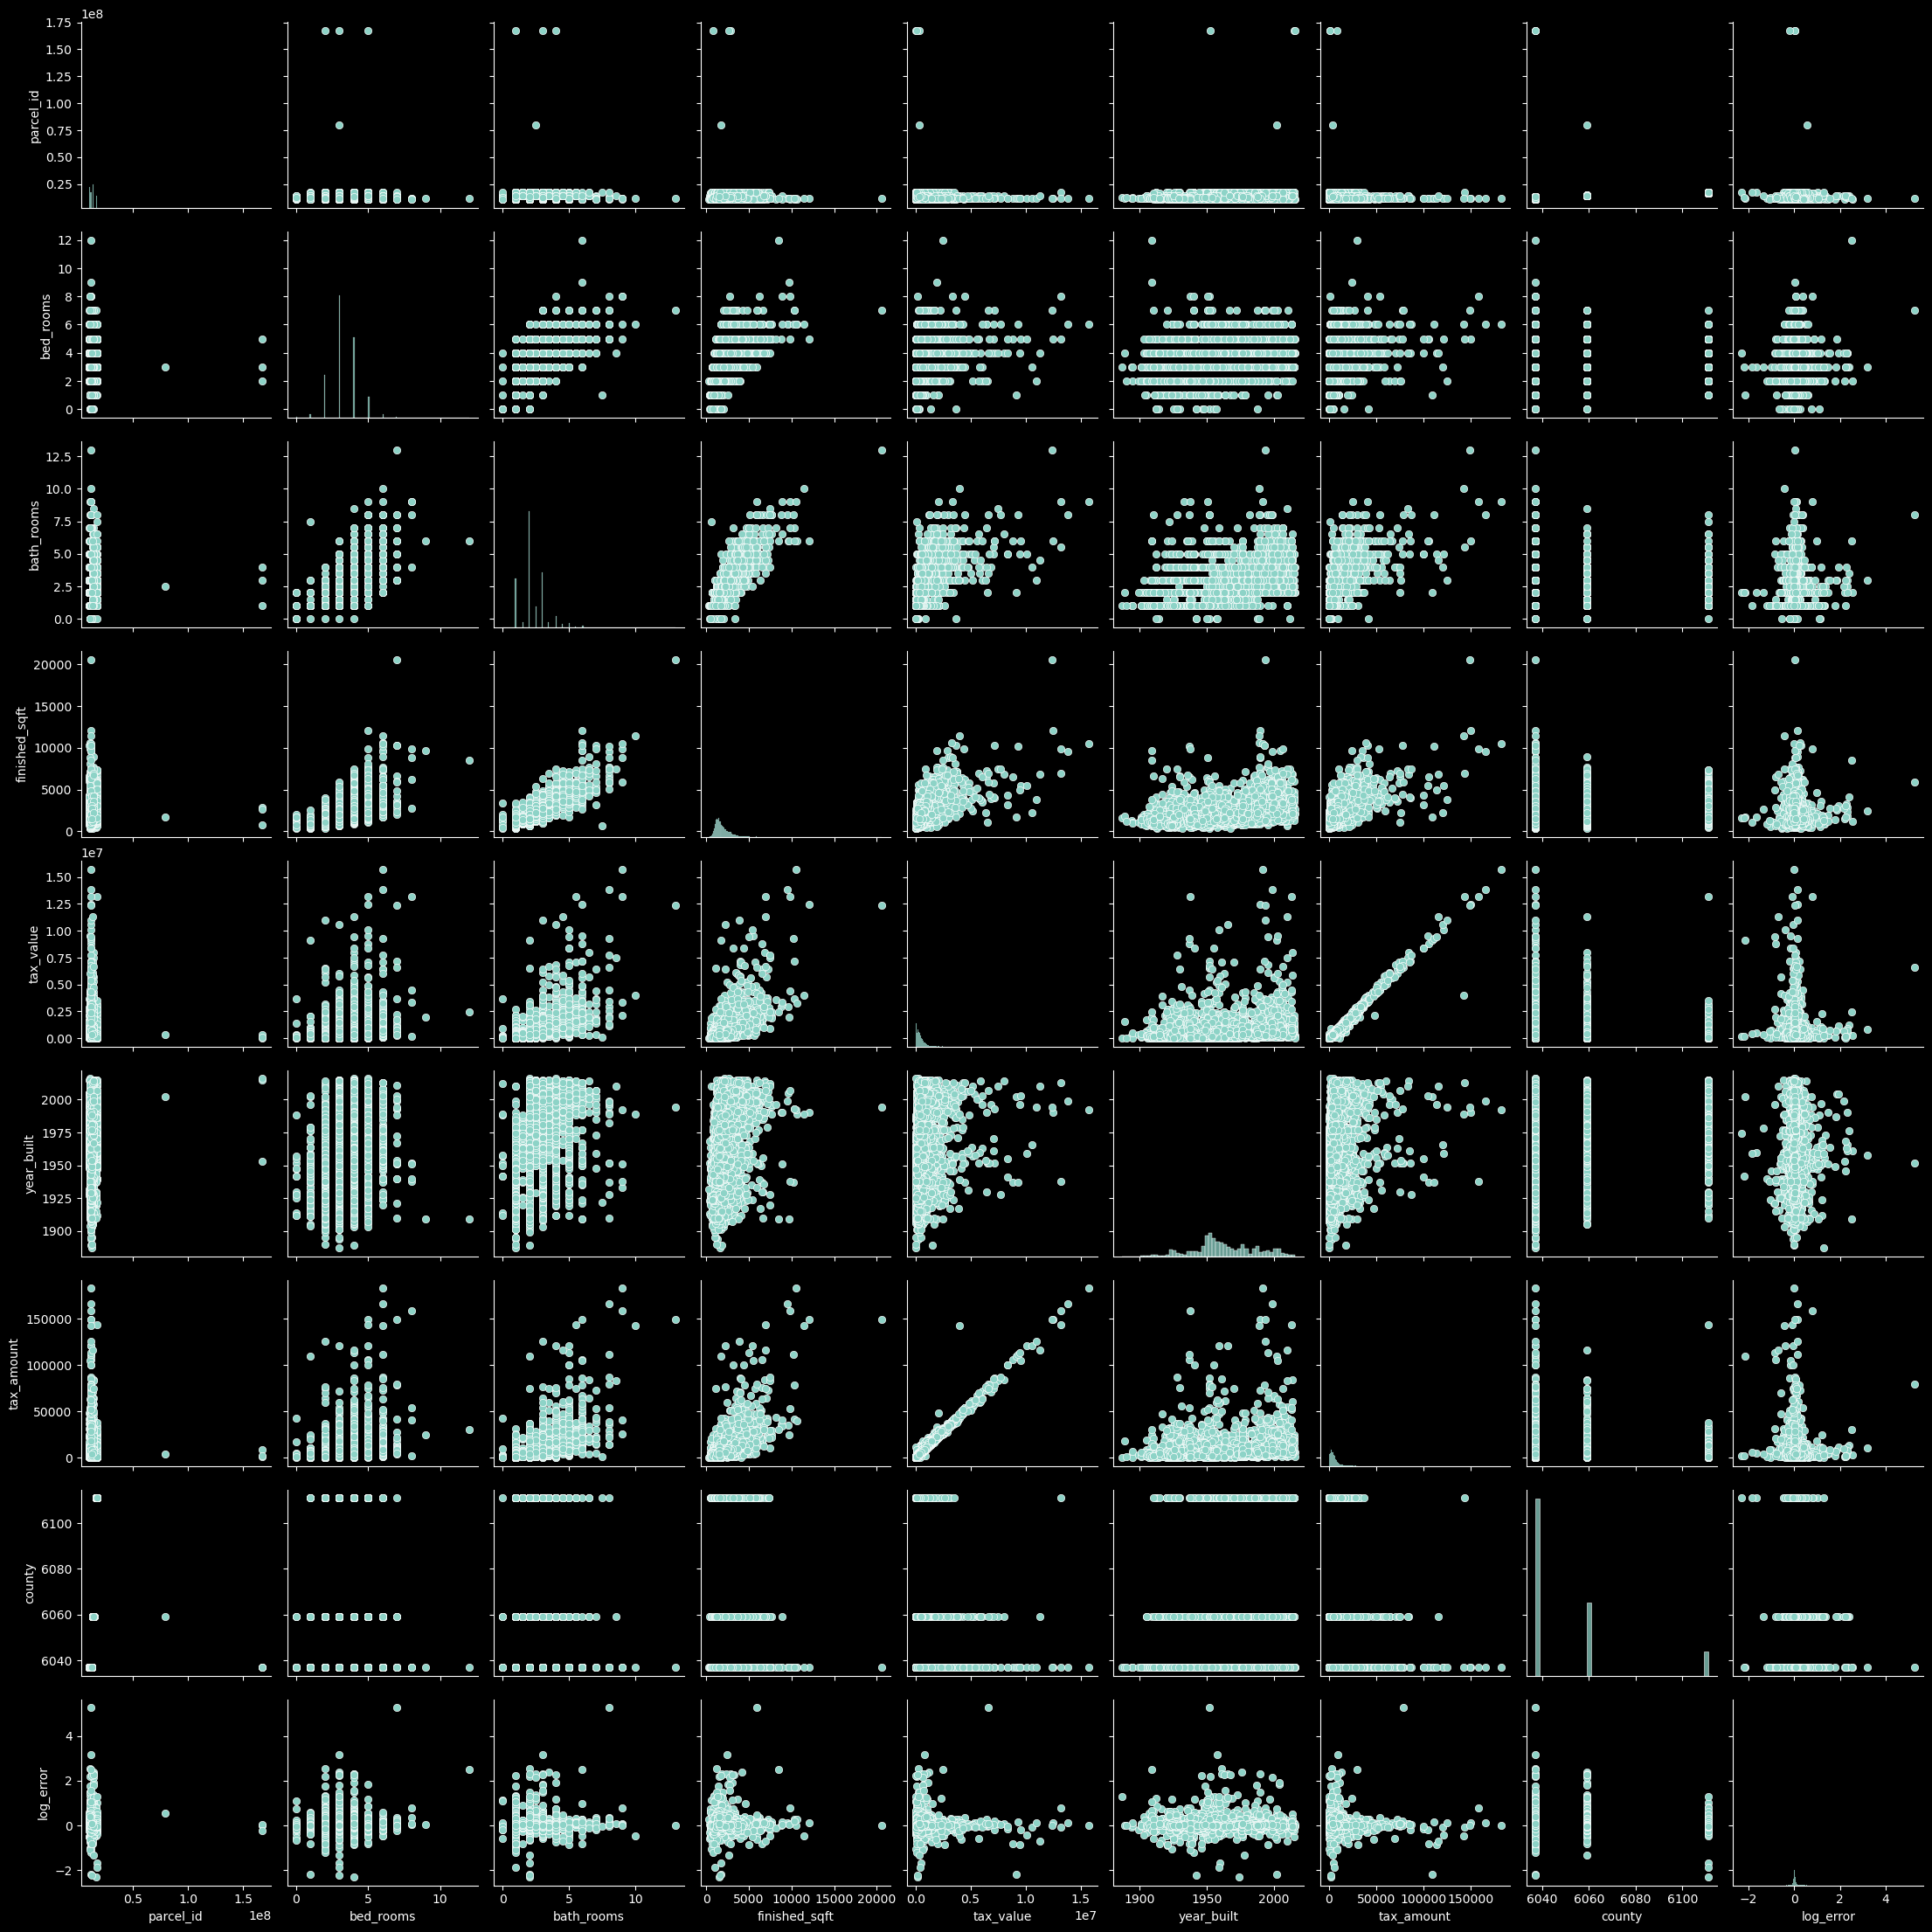

In [ ]:
sns.pairplot(data=train.sample(10000)) # inital look at the data 

## Notes form inital look at the data
- possible relationship between bathrooms and finished sqft  

<Axes: xlabel='tax_value', ylabel='Count'>

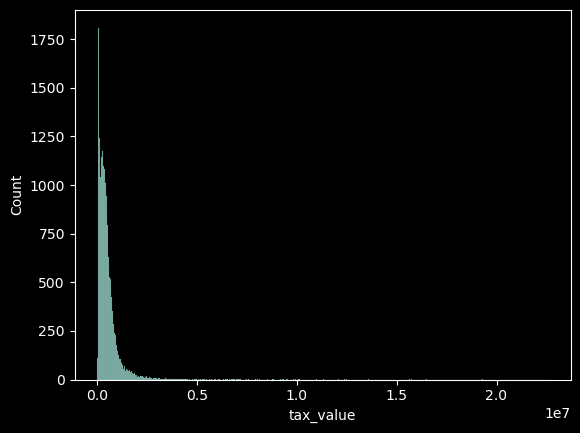

In [ ]:
sns.histplot(data=train.tax_value)

transaction_date
2017-06-30    463
2017-04-28    341
2017-07-28    323
2017-05-31    307
2017-08-31    297
             ... 
2017-05-20      1
2017-04-23      1
2017-01-14      1
2017-02-11      1
2017-09-17      1
Name: count, Length: 243, dtype: int64

## Questions 

### Does the time of year impact tax value? 

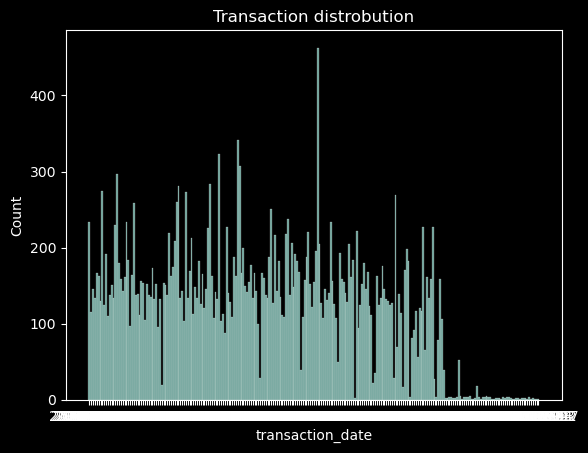

In [ ]:
sns.histplot(data=train, x='transaction_date')
plt.title('Transaction distrobution')
plt.show()

ValueError: could not convert string to float: '2017-05-05'

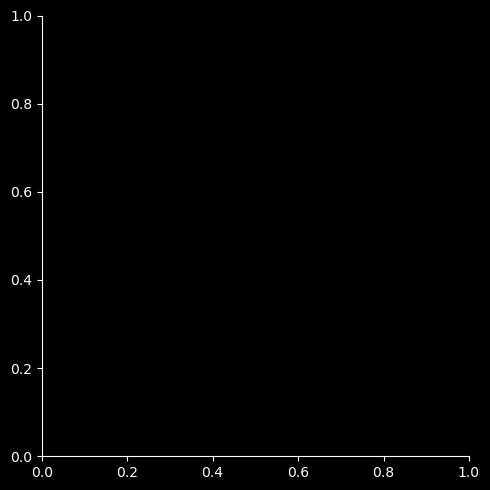

In [ ]:
sns.lmplot(x='transaction_date', y="tax_value", data=train, line_kws={'color': 'red'})
plt.title('Transaction distrobution')
plt.show()

# Question
## Does year built infuance tax value? 

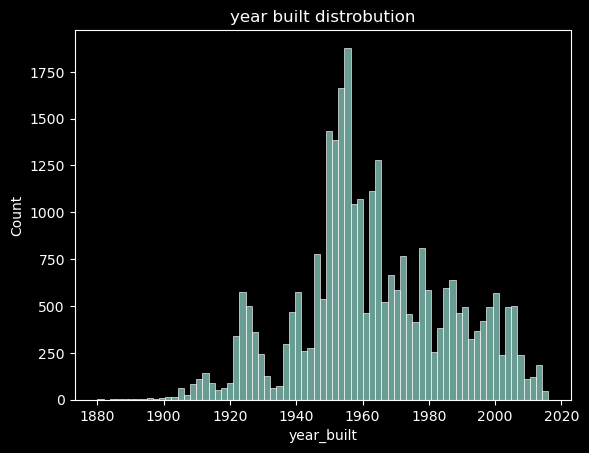

In [56]:
sns.histplot(data=train, x='year_built')
plt.title('year built distrobution')
plt.show()

- year built seems to have a normal distrobution 

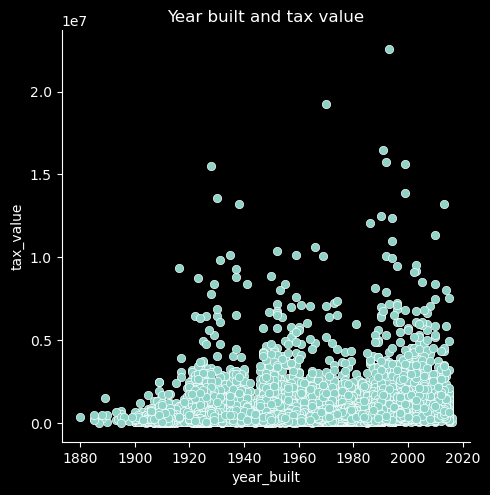

In [55]:
sns.relplot(data=train, x='year_built', y='tax_value')
plt.title('Year built and tax value')
plt.show()

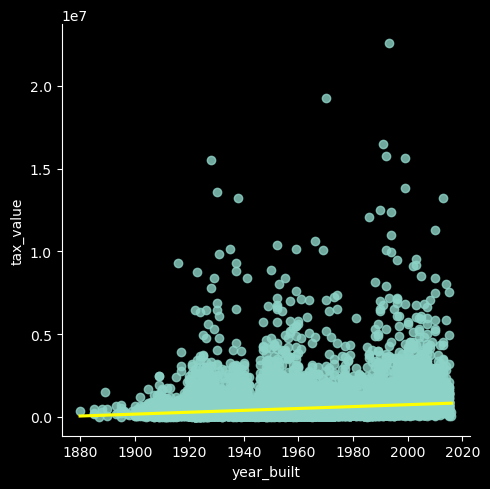

In [178]:
sns.lmplot(x='year_built', y="tax_value", data=train, line_kws={'color': 'yellow'})


- looks their is a positive correlation between year built and tax value 

     Note 
- year built is descrete
- tax value is continues 
- there is some sort of linear relationship between the two 

- we will have to use persons r

# Stats Test 
    
    Null - there is no linear correlation between year built and tax value 
    Alt - there is a linear correlation between year built and tax value 

In [66]:
from scipy import stats # imports 

alpha = 0.05 # set the alpha 


corr, p = stats.pearsonr(train.tax_value, train.year_built) # get the p value 
print(f'corr -> {corr}')
print(f'pvalue -> {p}')

if p < alpha: # compair p value our alpha value 
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

# Will be adding year built to my data dictionary 


corr -> 0.1824833263925857
pvalue -> 9.41054778519743e-218
We reject the null hypothesis


In [ ]:
def personsr_test(null, alt, val1, val2): 
    alpha = 0.05

# Question 

## Do number of bedrooms impact tax value? 

Text(0.5, 1.0, 'Distrobution of bedrooms')

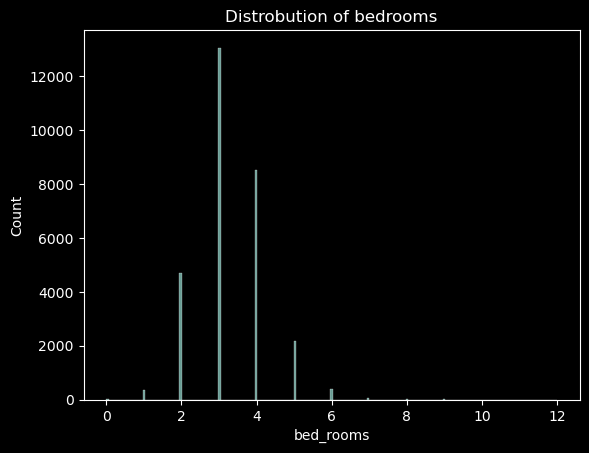

In [170]:
sns.histplot(data=train, x='bed_rooms')
plt.title('Distrobution of bedrooms')

- possibly normal or gamma distrobution 

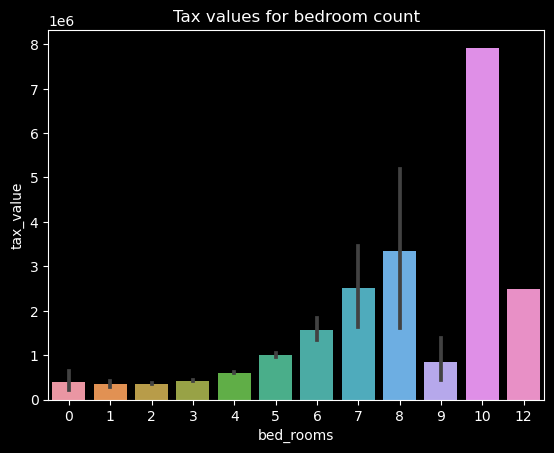

In [ ]:
sns.barplot(data=train, x='bed_rooms', y='tax_value')
plt.title('Tax values for bedroom count')
plt.show()

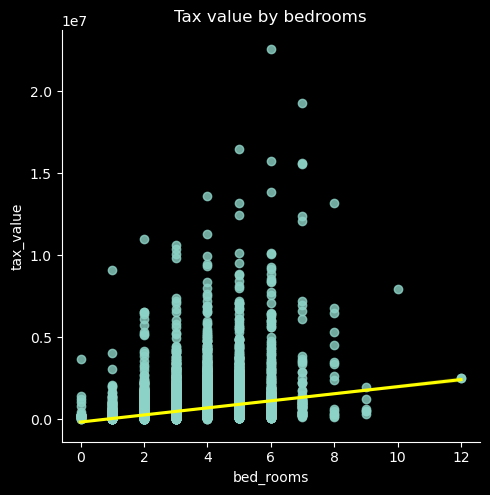

In [177]:
sns.lmplot(x='bed_rooms', y="tax_value", data=train, line_kws={'color': 'yellow'})
plt.title('Tax value by bedrooms')
plt.show()


     Note 
- bathrooms is descrete
- tax value is continues 
- there is some sort of linear relationship between the two 

- we will have to use persons r

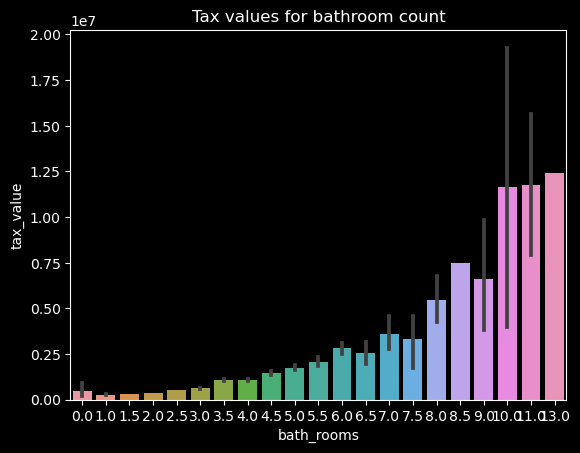

In [ ]:
sns.barplot(data=train, x='bath_rooms', y='tax_value')
plt.title('Tax values for bathroom count')
plt.show()

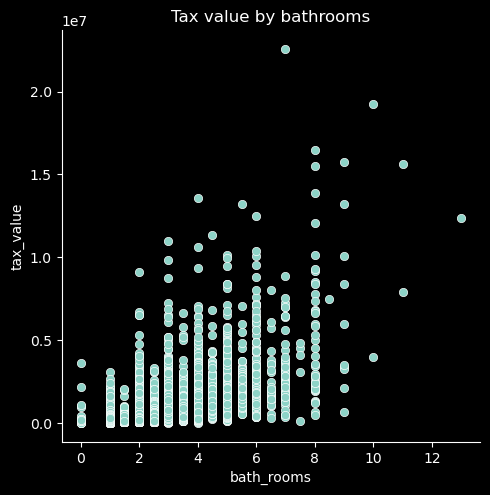

In [ ]:
sns.relplot(data=train, y='tax_value', x='bath_rooms')
plt.title('Tax value by bathrooms')
plt.show()

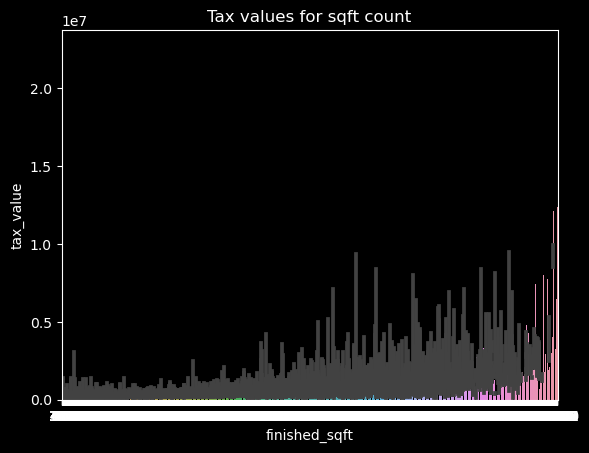

In [ ]:
sns.barplot(data=train, x='finished_sqft', y='tax_value')
plt.title('Tax values for sqft count')
plt.show()

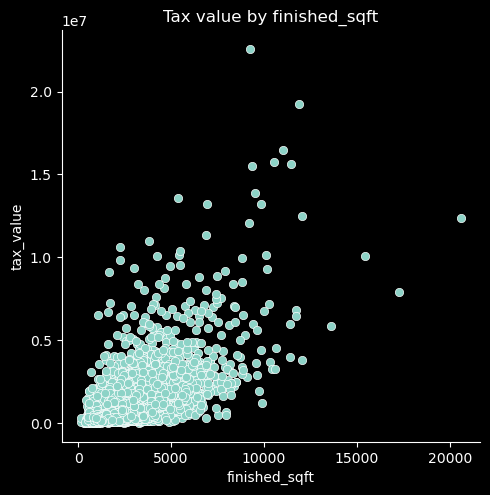

In [ ]:
sns.relplot(data=train, y='tax_value', x='finished_sqft')
plt.title('Tax value by finished_sqft')
plt.show()

## Question 
### What is the average sqft for a 3 bedroom single family propery? 

<function matplotlib.pyplot.show(close=None, block=None)>

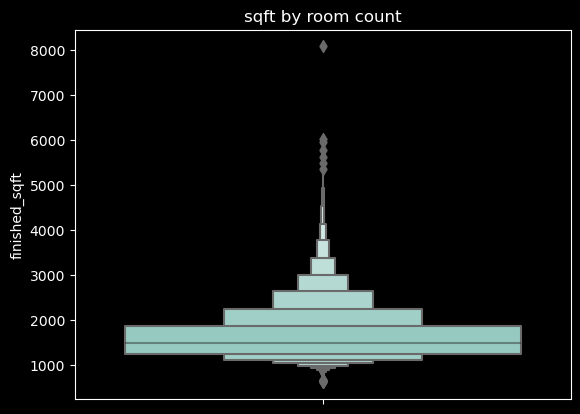

In [ ]:
sns.boxenplot(data= train[train.bed_rooms == 3], y= 'finished_sqft')
plt.title('sqft by room count')
plt.show

In [ ]:
train.head(1)

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
504114,Single Family Residential,14481410,4,2.5,2439,673754,1987,6850.0,6059,-0.122219,2017-05-05


# Data Dictionary

|Feature|Discription|
| - | - |
|bed_rooms|Number of bed rooms|
|bath_rooms|Number of bathrooms|
Finished_SQFT| usable space| 


# scale data 

In [69]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer # now that our data is split we can scale it

mms = MinMaxScaler() # creeating the scaler 
ss = StandardScaler() # creating the scaler
rs = RobustScaler() # creating the scaler 
qt = QuantileTransformer() # creating the scaler

In [68]:
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale=['bed_rooms', 'bath_rooms', 'tax_value', 'finished_sqft'],
               return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #     make the thing
    scaler = StandardScaler()
    #     fit the thing
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [71]:
def scale_train_data(train, 
               validate, 
               test, 
               cols_to_scale,
               scale,
               return_scaler=False):
    '''
    Scales the 3 data splits. 
    Takes in train, validate, and test data splits and returns their scaled counterparts.
    If return_scalar is True, the scaler object will be returned as well
    '''
    # make copies of our original data so we dont gronk up anything
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #     make the thing
    scaler = scale
    #     fit the thing
    scaler.fit(train[cols_to_scale])
    # applying the scaler:
    train_scaled[cols_to_scale] = pd.DataFrame(scaler.transform(train[cols_to_scale]),
                                                  columns=train[cols_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[cols_to_scale] = pd.DataFrame(scaler.transform(validate[cols_to_scale]),
                                                  columns=validate[cols_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[cols_to_scale] = pd.DataFrame(scaler.transform(test[cols_to_scale]),
                                                 columns=test[cols_to_scale].columns.values).set_index([test.index.values])
    
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

## Min Max Scaler

In [72]:
scaler, train_scaled_mm, validate_scaled_mm, test_scaled_mm = scale_data(train, validate, test, return_scaler=True)

In [73]:
train_scaled_mm.head(3)

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
504114,Single Family Residential,14481410,0.736082,0.198448,0.515067,0.200428,1987,6850.00,6059,-0.122219,2017-05-05
29686,Single Family Residential,12676325,-0.321819,-1.273381,-0.802571,0.247816,1954,8144.78,6037,-0.003290,2017-04-10
474808,Single Family Residential,12129843,-0.321819,0.689057,0.744437,0.603858,1979,11249.58,6037,0.080942,2017-07-13


# StandardScaler

In [74]:
scaler, train_scaled_ss, validate_scaled_ss, test_scaled_ss = scale_data(train, validate, test, return_scaler=True)

In [75]:
train_scaled_ss.head()

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
504114,Single Family Residential,14481410,0.736082,0.198448,0.515067,0.200428,1987,6850.00,6059,-0.122219,2017-05-05
29686,Single Family Residential,12676325,-0.321819,-1.273381,-0.802571,0.247816,1954,8144.78,6037,-0.003290,2017-04-10
474808,Single Family Residential,12129843,-0.321819,0.689057,0.744437,0.603858,1979,11249.58,6037,0.080942,2017-07-13
1526724,Single Family Residential,11203682,0.736082,-0.292162,-0.215740,-0.453739,1971,3323.01,6037,0.212506,2017-01-27
265675,Single Family Residential,14066903,-0.321819,-0.292162,-0.768810,-0.081940,1965,5395.32,6059,0.014152,2017-01-31


# RobustScaler

In [126]:
cols = ['bed_rooms', 'bath_rooms', 'finished_sqft']

train_scaled_rs, validate_scaled_rs, test_scaled_rs = scale_train_data(train, validate, test, scale=RobustScaler(),cols_to_scale= cols)

In [ ]:
train_scaled_rs.bed_rooms.max()

9.0

In [ ]:
train_scaled_rs.head()

,propertylandusedesc,parcel_id,bed_rooms,bath_rooms,finished_sqft,tax_value,year_built,tax_amount,county,log_error,transaction_date
504114,Single Family Residential,14481410,1.0,0.5,0.757986,0.706153,1987,6850.00,6059,-0.122219,2017-05-05
29686,Single Family Residential,12676325,0.0,-1.0,-0.526621,0.786433,1954,8144.78,6037,-0.003290,2017-04-10
474808,Single Family Residential,12129843,0.0,1.0,0.981607,1.389611,1979,11249.58,6037,0.080942,2017-07-13
1526724,Single Family Residential,11203682,1.0,0.0,0.045499,-0.402083,1971,3323.01,6037,0.212506,2017-01-27
265675,Single Family Residential,14066903,0.0,0.0,-0.493708,0.227788,1965,5395.32,6059,0.014152,2017-01-31


# split x and y

In [127]:
X_train = train_scaled_ss.drop(columns=['tax_value', 'propertylandusedesc', 'parcel_id', 'year_built', 'tax_amount', 'county', 'log_error', 'transaction_date'])

X_train.head(3)

,bed_rooms,bath_rooms,finished_sqft
504114,0.736082,0.198448,0.515067
29686,-0.321819,-1.273381,-0.802571
474808,-0.321819,0.689057,0.744437


In [77]:
X_validate = validate_scaled_ss.drop(columns=['tax_value', 'propertylandusedesc', 'parcel_id', 'year_built', 'tax_amount', 'county', 'log_error', 'transaction_date'])
X_test = test_scaled_ss.drop(columns=['tax_value', 'propertylandusedesc', 'parcel_id', 'year_built', 'tax_amount', 'county', 'log_error', 'transaction_date'])

In [128]:
y_train = train.tax_value
y_train.head()

504114     673754
29686      708000
474808     965305
1526724    201000
265675     469692
Name: tax_value, dtype: int64

In [129]:
y_validate = validate.tax_value
y_test = test.tax_value

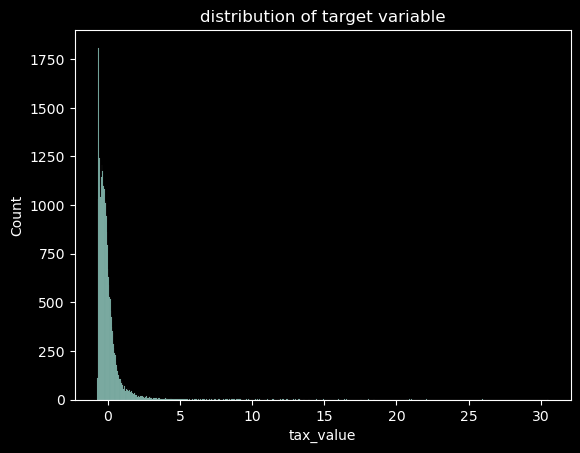

In [80]:
sns.histplot(y_train)
plt.title('distribution of target variable')
plt.show()

# baseline

In [130]:
baseline = y_train.mean()
baseline

528908.352846805

MMS
SS - 2.607296016323415e-17
RS

In [131]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [132]:
#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(train))
baseline_array[:5]

array([528908.35284681, 528908.35284681, 528908.35284681, 528908.35284681,
       528908.35284681])

In [133]:
rmse, r2 = metrics_reg(y_train, baseline_array)
rmse, r2

(722680.6434987412, 0.0)

SS - (1.0, 0.0)

In [134]:
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

,model,rmse,r2
0,baseline,722680.643499,0.0


# Ordinary Least Squares (OLS)

In [135]:
#import
from sklearn.linear_model import LinearRegression

### simple linear regression + RFE

send in only one feature

In [136]:
from sklearn.feature_selection import RFE

In [88]:
#intial ML model
lr1 = LinearRegression()

#make it
rfe = RFE(lr1, n_features_to_select=1)

#fit it
rfe.fit(X_train, y_train)

#use it on train
X_train_rfe = rfe.transform(X_train)

#use it on validate
X_val_rfe = rfe.transform(X_validate)

In [137]:
print('selected top feature:', rfe.get_feature_names_out())

selected top feature: ['finished_sqft']


#### build model from top feature

In [138]:
#fit the thing
lr1.fit(X_train_rfe, y_train)

#use the thing (make predictions)
pred_lr1 = lr1.predict(X_train_rfe)
pred_val_lr1 = lr1.predict(X_val_rfe)

In [139]:
pred_lr1[:10]

array([760858.74244906, 167486.24993157, 864151.16578858, 431753.87847553,
       182689.46375643, 654883.3990228 , 811387.07074934, 345006.12900425,
        42283.31255033, 207730.05123268])

### Evaluate

In [140]:
#train
metrics_reg(y_train, pred_lr1)

(565216.4550959036, 0.3883024392443286)

In [141]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr1)
rmse, r2

(659235.9223011846, 0.3397224587972567)

In [142]:
#add to my metrics df
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,722680.643499,0.000000
1,ols_1,659235.922301,0.339722


## Delete later

## examin model 

In [143]:
lr1.intercept_

528908.352846805

In [144]:
lr1.coef_

array([450330.62451556])

In [145]:
print(f'tax_value = {lr1.intercept_:.3} + {lr1.coef_[0]:.2}*fininished_sqft')

tax_value = 5.29e+05 + 4.5e+05*fininished_sqft


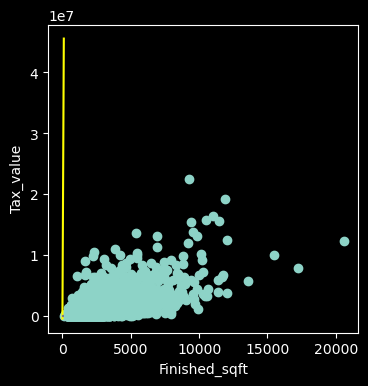

In [146]:
plt.figure(figsize=(4, 4))

plt.scatter(train.finished_sqft, train.tax_value)

#build prediction line from intercept and slope
x_val = np.array([-2, 100]).reshape(-1, 1)
plt.plot(x_val, lr1.intercept_ + x_val*lr1.coef_[0], c='yellow')

#intercept line
plt.hlines(22, -5, 100, ls=':', color='red')  

#(0,0) axis
plt.hlines(0, -5, 100, ls='--', color='grey')
plt.vlines(0, -10, 100, ls='--', color='grey')
 
plt.xlabel('Finished_sqft')
plt.ylabel('Tax_value')
plt.show()

### Multiple Regression

In [147]:
#make it
lr2 = LinearRegression()

#fit it on our RFE features
lr2.fit(X_train, y_train)

#use it (make predictions)
pred_lr2 = lr2.predict(X_train)

#use it on validate
pred_val_lr2 = lr2.predict(X_validate)

In [148]:
pred_lr2[:10]

array([679344.27700404,  90967.1558795 , 988925.86381205, 290731.60487689,
       187070.22880022, 527087.66426177, 772867.11947832, 359008.60466537,
       118509.4440305 , 373762.08799996])

### Evaluate

In [149]:
#train 
metrics_reg(y_train, pred_lr2)

(553690.2265923306, 0.41299625748441915)

In [150]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lr2)
rmse, r2

(651004.1307843225, 0.3561091032451851)

In [151]:
#add to my metrics df
metrics_df.loc[2] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,722680.643499,0.000000
1,ols_1,659235.922301,0.339722
2,ols,651004.130784,0.356109


# LassoLars

In [152]:
#import
from sklearn.linear_model import LassoLars

In [153]:
#make it
lars = LassoLars(alpha=1)

#fit it
lars.fit(X_train, y_train)

#use it
pred_lars = lars.predict(X_train)
pred_val_lars = lars.predict(X_validate)

In [154]:
#train
metrics_reg(y_train, pred_lars)

(553690.2265979549, 0.4129962574724938)

In [155]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_lars)
rmse, r2

(651004.1335118165, 0.35610909784980116)

In [156]:
#add to my metrics df
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,722680.643499,0.000000
1,ols_1,659235.922301,0.339722
2,ols,651004.130784,0.356109
3,lars,651004.133512,0.356109


# polynomial regression 

In [157]:
#import
from sklearn.preprocessing import PolynomialFeatures

In [158]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [159]:
#make it
pr = LinearRegression()

#fit it
pr.fit(X_train_degree2, y_train)

#use it
pred_pr = pr.predict(X_train_degree2)
pred_val_pr = pr.predict(X_validate_degree2)

In [160]:
#train
metrics_reg(y_train, pred_pr)

(529223.9992273315, 0.4637266498183584)

In [161]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_pr)
rmse, r2

(571227.3212682498, 0.5042499817149835)

In [162]:
#add to my metrics df
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,722680.643499,0.000000
1,ols_1,659235.922301,0.339722
2,ols,651004.130784,0.356109
3,lars,651004.133512,0.356109
4,poly_2,571227.321268,0.504250


In [163]:
len(X_train), len(y_train)

(29296, 29296)

In [164]:
y_train.head()

504114     673754
29686      708000
474808     965305
1526724    201000
265675     469692
Name: tax_value, dtype: int64

# Generalized Linear Model (GLM)

In [165]:
from sklearn.linear_model import TweedieRegressor

#make it
glm = TweedieRegressor(power=2, alpha=0)

#fit it
glm.fit(X_train, y_train)

#use it
pred_glm = glm.predict(X_train)
pred_val_glm = glm.predict(X_validate)

In [166]:
#train
metrics_reg(y_train, pred_glm)

(43594165.56083431, -3637.8478189317866)

In [167]:
#validate
rmse, r2 = metrics_reg(y_validate, pred_val_glm)
rmse, r2

(23293523.2050684, -823.3566769224777)

In [168]:
metrics_df.loc[5] = ['glm',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,7.226806e+05,0.000000
1,ols_1,6.592359e+05,0.339722
2,ols,6.510041e+05,0.356109
3,lars,6.510041e+05,0.356109
4,poly_2,5.712273e+05,0.504250
5,glm,2.329352e+07,-823.356677


# Evaluate on the best model 

In [ ]:
#use it
pred_test = pr.predict(X_test_degree2)
pred_test

array([0.01074987, 0.02586224, 0.02925673, ..., 0.0179825 , 0.01629495,
       0.00686033])

In [ ]:
rmse, r2 = metrics_reg(y_test, pred_test)
rmse, r2

(0.025058966237078248, 0.416010191248647)

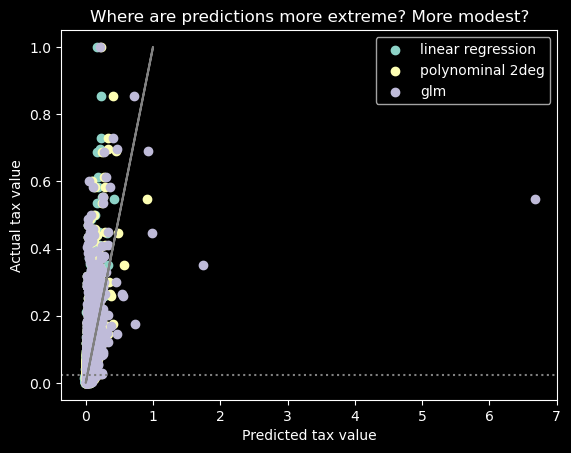

In [ ]:
plt.scatter(pred_lr2, y_train, label='linear regression')
plt.scatter(pred_pr, y_train, label='polynominal 2deg')
plt.scatter(pred_glm, y_train, label='glm')
plt.plot(y_train, y_train, label='_nolegend_', color='grey')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate("Baseline", (65, 81))

plt.title("Where are predictions more extreme? More modest?")
plt.ylabel("Actual tax value")
plt.xlabel("Predicted tax value")
plt.legend()

plt.show()

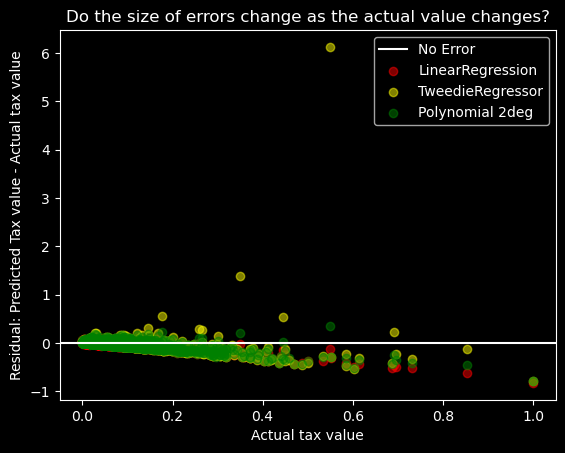

In [ ]:
plt.axhline(label="No Error")

plt.scatter(y_train, pred_lr2 - y_train, alpha=.5, color="red", label="LinearRegression")
plt.scatter(y_train, pred_glm - y_train, alpha=.5, color="yellow", label="TweedieRegressor")
plt.scatter(y_train, pred_pr - y_train, alpha=.5, color="green", label="Polynomial 2deg ")

plt.legend()
plt.title("Do the size of errors change as the actual value changes?")
plt.xlabel("Actual tax value")
plt.ylabel("Residual: Predicted Tax value - Actual tax value")

plt.show()